In [10]:
# ===============================================
# LSTM + CTC Grapheme-to-Phoneme (G2P) model
# ===============================================
# This model replaces the zero-delay Nettalk baseline with a sequence model
# that learns alignment automatically using Connectionist Temporal Classification (CTC).
# It follows the setup in the Google G2P paper and can handle variable-length mappings.
# ===============================================

import re
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from tqdm import tqdm
import matplotlib.pyplot as plt

# -------------------
# Configuration
# -------------------
CMU_DICT_PATH = "cmudict.dict.txt"
STRIP_STRESS = True
MAX_WORDS = None       # for quick tests, e.g. 20000; set None for full dict
BATCH_SIZE = 32
EMBED_DIM = 64
HIDDEN_DIM = 256
EPOCHS = 10
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------
# Data Loading
# -------------------
def load_cmudict(path, max_words=None):
    entries = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip() or line.startswith(";;;"):
                continue
            parts = line.strip().split()
            word = re.sub(r"\(\d+\)$", "", parts[0]).lower()
            phones = parts[1:]
            if STRIP_STRESS:
                phones = [re.sub(r"\d+$", "", p) for p in phones]
            entries.append((word, phones))
            if max_words and len(entries) >= max_words:
                break
    return entries

entries = load_cmudict(CMU_DICT_PATH, MAX_WORDS)
print(f"Loaded {len(entries)} CMUdict entries")

# Build vocabularies
graphemes = sorted({c for w, _ in entries for c in w})
phones = sorted({p for _, phs in entries for p in phs})
graphemes = ["<pad>", "<s>", "</s>"] + graphemes
phones = ["<blank>"] + phones  # CTC blank token at index 0

char2idx = {c: i for i, c in enumerate(graphemes)}
idx2char = {i: c for c, i in char2idx.items()}
phone2idx = {p: i for i, p in enumerate(phones)}
idx2phone = {i: p for p, i in phone2idx.items()}

# -------------------
# Dataset
# -------------------
class G2PCTCDataset(Dataset):
    def __init__(self, entries, char2idx, phone2idx):
        self.data = []
        for word, ph_seq in entries:
            x = [char2idx[c] for c in word]
            y = [phone2idx[p] for p in ph_seq]
            self.data.append((torch.tensor(x), torch.tensor(y)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_batch(batch):
    x_seqs, y_seqs = zip(*batch)
    x_lens = torch.tensor([len(x) for x in x_seqs])
    y_lens = torch.tensor([len(y) for y in y_seqs])
    x_pad = pad_sequence(x_seqs, batch_first=False, padding_value=char2idx["<pad>"])
    y_cat = torch.cat(y_seqs)
    return x_pad, x_lens, y_cat, y_lens

# Split into train/dev/test
random.seed(42)
random.shuffle(entries)
n = len(entries)
train_entries = entries[: int(0.85 * n)]
dev_entries = entries[int(0.85 * n) : int(0.93 * n)]
test_entries = entries[int(0.93 * n) :]

train_loader = DataLoader(G2PCTCDataset(train_entries, char2idx, phone2idx),
                          batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
dev_loader = DataLoader(G2PCTCDataset(dev_entries, char2idx, phone2idx),
                        batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(G2PCTCDataset(test_entries, char2idx, phone2idx),
                         batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

# -------------------
# Model
# -------------------
class LSTMCTCModel(nn.Module):
    def __init__(self, n_chars, embed_dim, hidden_dim, n_phones, num_layers=2, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(n_chars, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=False, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, n_phones)  # bidirectional
    def forward(self, x, lengths):
        emb = self.embed(x)  # (T,B,E)
        packed = pack_padded_sequence(emb, lengths.cpu(), enforce_sorted=False)
        out, _ = self.lstm(packed)
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(out)
        logits = self.fc(out)  # (T,B,num_phones)
        log_probs = torch.log_softmax(logits, dim=2)
        return log_probs

# -------------------
# Training
# -------------------
model = LSTMCTCModel(len(char2idx), EMBED_DIM, HIDDEN_DIM, len(phone2idx)).to(DEVICE)
criterion = nn.CTCLoss(blank=phone2idx["<blank>"], zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Helpers for evaluation
def split_targets(y_cat, y_lens):
    # y_cat: 1D tensor of concatenated phone indices (CPU tensor expected)
    outs = []
    idx = 0
    for l in y_lens.tolist():
        seq = [idx2phone[int(x)] for x in y_cat[idx: idx + l]]
        outs.append(seq)
        idx += l
    return outs

def edit_distance(a, b):
    n, m = len(a), len(b)
    dp = [[0] * (m + 1) for _ in range(n + 1)]
    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = 0 if a[i - 1] == b[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1, dp[i][j - 1] + 1, dp[i - 1][j - 1] + cost)
    return dp[n][m]

print("Training LSTM+CTC model...")

# Tracking metrics
train_losses = []
dev_pers = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0
    for xb, xlens, yb, ylens in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        log_probs = model(xb, xlens)  # (T,B,C)
        loss = criterion(log_probs, yb, xlens, ylens)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f}")

    # --- Evaluate on dev set (compute PER) ---
    model.eval()
    ed_sum = 0
    total_ref_phones = 0
    with torch.no_grad():
        for xb, xlens, yb, ylens in dev_loader:
            xb = xb.to(DEVICE)
            log_probs = model(xb, xlens)  # (T,B,C)
            preds = greedy_decode_ctc(log_probs)  # list of phone lists
            # build references from concatenated yb
            refs = split_targets(yb.cpu(), ylens)
            for p, r in zip(preds, refs):
                ed_sum += edit_distance(p, r)
                total_ref_phones += max(1, len(r))
    per = ed_sum / max(1, total_ref_phones)
    dev_pers.append(per)
    print(f"Epoch {epoch} | Dev PER: {per*100:.2f}%")

torch.save({
    "model_state": model.state_dict(),
    "char2idx": char2idx,
    "phone2idx": phone2idx,
    "idx2phone": idx2phone,
    "train_losses": train_losses,
    "dev_pers": dev_pers
}, "lstm_ctc_g2p.pth")

print("Training complete, model saved to lstm_ctc_g2p.pth")


Loaded 135166 CMUdict entries
Training LSTM+CTC model...
Training LSTM+CTC model...


Epoch 1 | Train Loss: 0.4061
Epoch 1 | Dev PER: 10.52%
Epoch 1 | Dev PER: 10.52%


Epoch 2 | Train Loss: 0.2650
Epoch 2 | Dev PER: 9.27%
Epoch 2 | Dev PER: 9.27%


Epoch 3 | Train Loss: 0.2279
Epoch 3 | Dev PER: 8.64%
Epoch 3 | Dev PER: 8.64%


Epoch 4 | Train Loss: 0.2011
Epoch 4 | Dev PER: 8.46%
Epoch 4 | Dev PER: 8.46%


Epoch 5 | Train Loss: 0.1803
Epoch 5 | Dev PER: 8.33%
Epoch 5 | Dev PER: 8.33%


Epoch 6 | Train Loss: 0.1633
Epoch 6 | Dev PER: 8.13%
Epoch 6 | Dev PER: 8.13%


Epoch 7 | Train Loss: 0.1501
Epoch 7 | Dev PER: 7.98%
Epoch 7 | Dev PER: 7.98%


Epoch 8 | Train Loss: 0.1401
Epoch 8 | Dev PER: 8.07%
Epoch 8 | Dev PER: 8.07%


Epoch 9 | Train Loss: 0.1314
Epoch 9 | Dev PER: 8.02%
Epoch 9 | Dev PER: 8.02%


Epoch 10 | Train Loss: 0.1245
Epoch 10 | Dev PER: 8.19%
Training complete, model saved to lstm_ctc_g2p.pth
Epoch 10 | Dev PER: 8.19%
Training complete, model saved to lstm_ctc_g2p.pth


In [11]:
# ==============================
# Inference: decode CTC outputs
# ==============================

def greedy_decode_ctc(log_probs):
    """Greedy CTC decoding: take argmax over time and collapse repeats/blanks."""
    indices = log_probs.argmax(dim=2).cpu().numpy().T  # shape (B, T)
    preds = []
    for seq in indices:
        prev = None
        out = []
        for i in seq:
            p = idx2phone[i]
            if p == "<blank>":
                prev = p
                continue
            if p != prev:
                out.append(p)
            prev = p
        preds.append(out)
    return preds

# Load model
ckpt = torch.load("lstm_ctc_g2p.pth", map_location=DEVICE)
model = LSTMCTCModel(len(char2idx), EMBED_DIM, HIDDEN_DIM, len(phone2idx)).to(DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()

def predict_g2p(word: str):
    seq = torch.tensor([[char2idx.get(c, 0) for c in word.lower()]], dtype=torch.long).T
    length = torch.tensor([seq.size(0)], dtype=torch.long)
    with torch.no_grad():
        log_probs = model(seq.to(DEVICE), length)  # (T,1,C)
    decoded = greedy_decode_ctc(log_probs)[0]
    return decoded

# Test a few words
test_words = ["google", "physics", "algorithm", "data", "chatgpt"]
for w in test_words:
    phones_pred = predict_g2p(w)
    print(f"{w:>12s} → {' '.join(phones_pred)}")


      google → G UW G AH L
     physics → F IH Z IH K S
   algorithm → AE L G ER IH DH AH M
        data → D EY T AH
     chatgpt → CH AE T P T


In [12]:
# ==========================================
# Compare LSTM-CTC predictions with CMUdict
# ==========================================

# Reload CMUdict (same helper as before)
cmu_entries = load_cmudict(CMU_DICT_PATH)
cmu_dict = {w: phs for w, phs in cmu_entries}

# Pick some test words (must exist in CMUdict)
test_words = ["google", "physics", "algorithm", "data", "chatgpt"]

for w in test_words:
    pred = predict_g2p(w)
    ref = cmu_dict.get(w.lower(), ["<missing>"])
    print(f"\nWord: {w}")
    print(f"Predicted: {' '.join(pred)}")
    print(f"Reference: {' '.join(ref)}")

    # --- simple alignment-based accuracy summary ---
    # compute edit distance between predicted and reference phonemes
    def edit_distance(a, b):
        n, m = len(a), len(b)
        dp = [[0]*(m+1) for _ in range(n+1)]
        for i in range(n+1):
            dp[i][0] = i
        for j in range(m+1):
            dp[0][j] = j
        for i in range(1, n+1):
            for j in range(1, m+1):
                cost = 0 if a[i-1] == b[j-1] else 1
                dp[i][j] = min(dp[i-1][j]+1, dp[i][j-1]+1, dp[i-1][j-1]+cost)
        return dp[n][m]

    ed = edit_distance(pred, ref)
    per = ed / max(1, len(ref))
    print(f"Phoneme Error Rate (PER): {per*100:.1f}%")



Word: google
Predicted: G UW G AH L
Reference: G UW G AH L
Phoneme Error Rate (PER): 0.0%

Word: physics
Predicted: F IH Z IH K S
Reference: F IH Z IH K S
Phoneme Error Rate (PER): 0.0%

Word: algorithm
Predicted: AE L G ER IH DH AH M
Reference: AE L G ER IH DH AH M
Phoneme Error Rate (PER): 0.0%

Word: data
Predicted: D EY T AH
Reference: D AE T AH
Phoneme Error Rate (PER): 25.0%

Word: chatgpt
Predicted: CH AE T P T
Reference: <missing>
Phoneme Error Rate (PER): 500.0%


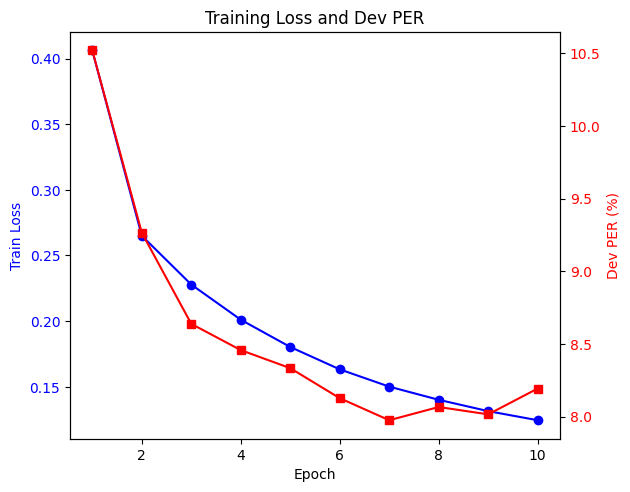

In [13]:
# Plot training loss and dev PER (if available in memory or checkpoint)
try:
    # If running after training in same session, use lists from memory
    xs = list(range(1, len(train_losses) + 1))
    losses = train_losses
    pers = [p * 100 for p in dev_pers]
except NameError:
    # Otherwise try loading from checkpoint file
    ckpt = torch.load("lstm_ctc_g2p.pth", map_location=DEVICE)
    losses = ckpt.get("train_losses", [])
    pers = [p * 100 for p in ckpt.get("dev_pers", [])]
    xs = list(range(1, len(losses) + 1))

if len(xs) == 0:
    print("No training metrics found to plot.")
else:
    fig, ax1 = plt.subplots()
    ax1.plot(xs, losses, 'b-o', label='Train Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.plot(xs, pers, 'r-s', label='Dev PER (%)')
    ax2.set_ylabel('Dev PER (%)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    fig.tight_layout()
    plt.title('Training Loss and Dev PER')
    plt.show()